In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
patrickfleith_nasa_battery_dataset_path = kagglehub.dataset_download('patrickfleith/nasa-battery-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'nasa-battery-dataset' dataset.
Data source import complete.


# Calculating SoH for battery.

First import the metadata file. which contains the type of the cycle files for over 7000+ files.
Which gives us to get the discharge files where the dishcharge cycle is more importatnt in caculation of State of Health prediction.

In [2]:
import pandas as pd

metadata = pd.read_csv('/kaggle/input/nasa-battery-dataset/cleaned_dataset/metadata.csv')
metadata.head()


,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN


In [3]:
#extracting the columns
print(metadata.columns)


Index(['type', 'start_time', 'ambient_temperature', 'battery_id', 'test_id',
       'uid', 'filename', 'Capacity', 'Re', 'Rct'],
      dtype='object')


Now we need to extract the discharge files from the data as per given in the meta data.

In [4]:
discharge_meta = metadata[
    metadata['type'].str.lower() == 'discharge'
]

discharge_files = discharge_meta['filename'].astype(str).tolist()

discharge_files[:5]

['00001.csv', '00005.csv', '00007.csv', '00009.csv', '00011.csv']

taking out the capacity column and null values

In [5]:
discharge_meta['Capacity'].isna().sum(), len(discharge_meta)


(np.int64(0), 2794)

In [6]:
discharge_meta = discharge_meta.copy()

discharge_meta['Capacity'] = pd.to_numeric(
    discharge_meta['Capacity'],
    errors='coerce'
)


In [7]:
print(discharge_meta['Capacity'].dtype)
print(discharge_meta['Capacity'].isna().sum())


float64
25


25 NaNs Exist That’s <1% missing, which is very manageable.
So Drop those Cycles.This is the standard approach for SOH

In [8]:
discharge_meta = discharge_meta.copy()

discharge_meta['Capacity'] = pd.to_numeric(
    discharge_meta['Capacity'],
    errors='coerce'
)

discharge_meta = discharge_meta.dropna(subset=['Capacity'])
discharge_meta = discharge_meta.reset_index(drop=True)


Re-check: expected 0


In [9]:
discharge_meta['Capacity'].isna().sum()


np.int64(0)

Recompute SOH (Now Clean)

In [10]:
import numpy as np

capacity = discharge_meta['Capacity'].values
SOH = capacity / capacity[0]


FINAL SOH SANITY CHECK

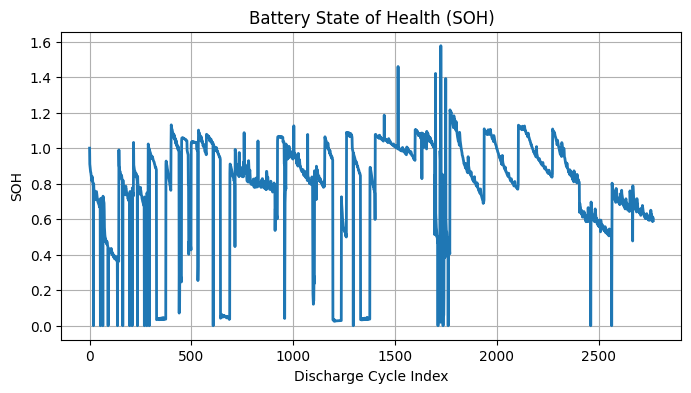

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(SOH, linewidth=2)
plt.xlabel("Discharge Cycle Index")
plt.ylabel("SOH")
plt.title("Battery State of Health (SOH)")
plt.grid(True)
plt.show()


What Exactly Was Plotted?
Let’s break it down precisely.

What discharge_meta contains : Each row in discharge_meta represents ONE discharge cycle, not one battery file alone.
battery_id -> which battery
filename -> which raw file (00001.csv, 00005.csv, …)
Capacity -> discharge capacity for that cycle
so we did this
"capacity = discharge_meta['Capacity'].values
 SOH = capacity / capacity[0]
 plt.plot(SOH)"

 We plotted SOH vs discharge-cycle index across ALL batteries
 This is a global degradation trend


 For a single battery curve follow next step


Plot SoH for One Battery
First select a battery.

In [12]:
battery_id = discharge_meta['battery_id'].iloc[0]


Filter that battery

In [13]:
battery_df = discharge_meta[
    discharge_meta['battery_id'] == battery_id
].copy()

battery_df = battery_df.sort_values('start_time').reset_index(drop=True)


Compute SoH for THIS battery

In [14]:
capacity = battery_df['Capacity'].values
SOH = capacity / capacity[0]


Plot

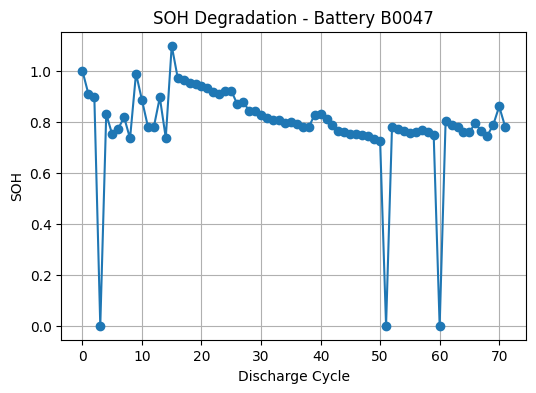

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(SOH, marker='o')
plt.xlabel("Discharge Cycle")
plt.ylabel("SOH")
plt.title(f"SOH Degradation - Battery {battery_id}")
plt.grid(True)
plt.show()


SoH method used right now is Capacity-based State of Health (Industry Standard)

                         Formula =     SoHi = C0/Ci

Where:
      Ci = discharge capacity at cycle i
      C0 = initial discharge capacity of the same battery

Where the capacity comes from?
 We are using metadata-provided discharge capacity, not raw integration.

Specifically:
             Source: metadata.csv
             Column: Capacity
             This capacity is: measured per discharge cycle and already integrated by the experiment                                setup
             validated (NaNs removed)

So SoH pipeline is:

                             Metadata (Capacity)
                                     |
                           Filter discharge cycles
                                     |
                             Group by battery_id
                                     |
                             Sort by cycle time
                                     |
                    SOH = Capacity / first Capacity of that battery



# Coulomb Counting–Based SOH

Core Idea

Battery capacity is proportional to the total charge delivered during discharge.

                               C=∫I(t)dt

                         then SoH =>  SOH = Ci/C0

Data Required from raw discharge files (00001.csv, etc.):
Current_measured
Time

How It Works (Step-by-Step)
Integrate discharge current over time -> capacity (Ah)
Repeat for each discharge cycle
Normalize by first cycle capacity

In [18]:
import pandas as pd
import numpy as np

file_path = "/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/00001.csv"
df = pd.read_csv(file_path)

df.head()


,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time
0,4.246711,0.000252,6.212696,0.0002,0.000,0.000
1,4.246764,-0.001411,6.234019,0.0002,4.262,9.360
2,4.039277,-0.995093,6.250255,1.0000,3.465,23.281
3,4.019506,-0.996731,6.302176,1.0000,3.451,36.406
4,4.004763,-0.992845,6.361645,1.0000,3.438,49.625


In [19]:
df.columns


Index(['Voltage_measured', 'Current_measured', 'Temperature_measured',
       'Current_load', 'Voltage_load', 'Time'],
      dtype='object')

Coulomb counting function and Compute capacity for this discharge cycle

In [20]:
import numpy as np

def coulomb_capacity(time_s, current_a):
    time_h = time_s / 3600
    return np.trapz(np.abs(current_a), time_h)

capacity_i = coulomb_capacity(
    df['Time'].values,
    df['Current_measured'].values
)

capacity_i


/tmp/ipython-input-3008620934.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(np.abs(current_a), time_h)


np.float64(1.7059340104658989)

to confirm everything is working properly compute SoH through baseline method
This should give answer = 1.0


In [21]:
capacity_0 = capacity_i
SOH_i = capacity_i / capacity_0
SOH_i


np.float64(1.0)

Loop over ALL discharge files

In [22]:
base_path = "/kaggle/input/nasa-battery-dataset/cleaned_dataset/data"

capacities = []

for fname in discharge_files:
    file_path = f"{base_path}/{fname}"
    df = pd.read_csv(file_path)

    cap = coulomb_capacity(
        df['Time'].values,
        df['Current_measured'].values
    )
    capacities.append(cap)

capacities = np.array(capacities)
SOH_cc = capacities / capacities[0]


Streaming output truncated to the last 5000 lines.
/tmp/ipython-input-3008620934.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(np.abs(current_a), time_h)
/tmp/ipython-input-3008620934.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(np.abs(current_a), time_h)
/tmp/ipython-input-3008620934.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(np.abs(current_a), time_h)
/tmp/ipython-input-3008620934.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(np.abs(current_a), time_h)
/tmp/ipython-input-3008620934.py:5: DeprecationWarning: `trapz` is deprecated. Us

Plot Coulomb-counting SoH

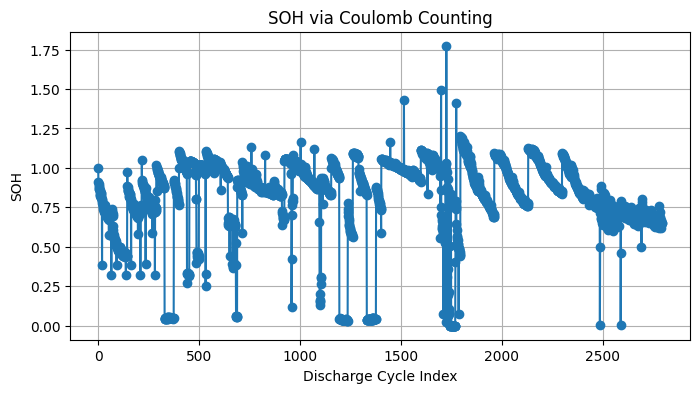

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(SOH_cc, marker='o')
plt.xlabel("Discharge Cycle Index")
plt.ylabel("SOH")
plt.title("SOH via Coulomb Counting")
plt.grid(True)
plt.show()


# Voltage-Based SoH

concept

As a battery degrades:

                     Discharge voltage drops faster
                     Average voltage decreases
                     Voltage curve shape changes
So we estimate SOH using voltage features instead of integrating current.
                         
                     SoH=f(Voltage Features)


Data Used (From discharged file)

                     Voltage_measured
                     Time

Temperature_measured (optional and I didn't used)


Extract Voltage Features

    Feature	                            Meaning
     V_mean	                          Average discharge voltage
     V_min	                          End-of-discharge voltage
     V_std	                          Voltage variability
     V_area	                          Area under voltage–time curve

In [16]:
def extract_voltage_features(df):
    features = {}

    v = df['Voltage_measured'].values
    t = df['Time'].values

    features['V_mean'] = v.mean()
    features['V_min'] = v.min()
    features['V_std'] = v.std()
    features['V_area'] = np.trapz(v, t)

    return features


Build Voltage Feature Dataset

In [24]:
base_path = "/kaggle/input/nasa-battery-dataset/cleaned_dataset/data"

X_voltage = []
y_soh = []

for i, fname in enumerate(discharge_files):
    df = pd.read_csv(f"{base_path}/{fname}")

    feats = extract_voltage_features(df)
    X_voltage.append(list(feats.values()))
    y_soh.append(SOH_cc[i])  # Coulomb-counted SOH

X_voltage = np.array(X_voltage)
y_soh = np.array(y_soh)


Streaming output truncated to the last 5000 lines.
/tmp/ipython-input-3695518921.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  features['V_area'] = np.trapz(v, t)
/tmp/ipython-input-3695518921.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  features['V_area'] = np.trapz(v, t)
/tmp/ipython-input-3695518921.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  features['V_area'] = np.trapz(v, t)
/tmp/ipython-input-3695518921.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  features['V_area'] = np.trapz(v, t)
/tmp/ipython-input-3695518921.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, 

Train - Test Split

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_voltage, y_soh, test_size=0.2, random_state=42
)


Voltage-Based SoH Using Random Forest
This converts voltage-based SoH into ML-estimated SoH.

Model Train

In [27]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, random_state=42)

Evaluate
Lower the value better the SoH prediction


In [28]:
from sklearn.metrics import mean_absolute_error

y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

mae


0.01609842398191085

Plot Prediction vs True SOH

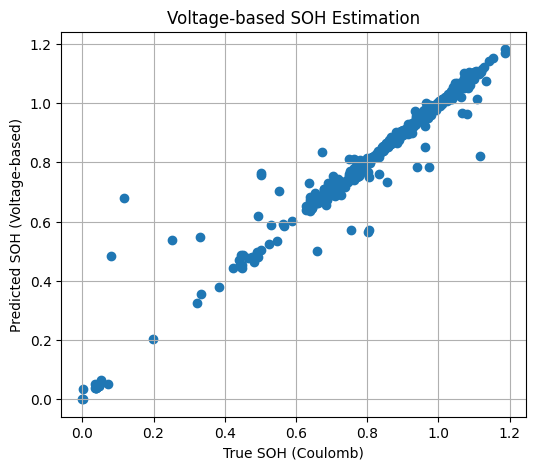

In [29]:
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred)
plt.xlabel("True SOH (Coulomb)")
plt.ylabel("Predicted SOH (Voltage-based)")
plt.title("Voltage-based SOH Estimation")
plt.grid(True)
plt.show()


In [30]:
SOH_voltage_ml = rf.predict(X_voltage)
SOH_voltage_ml = np.clip(SOH_voltage_ml, 0, 1.05)


SoH plot over cycles

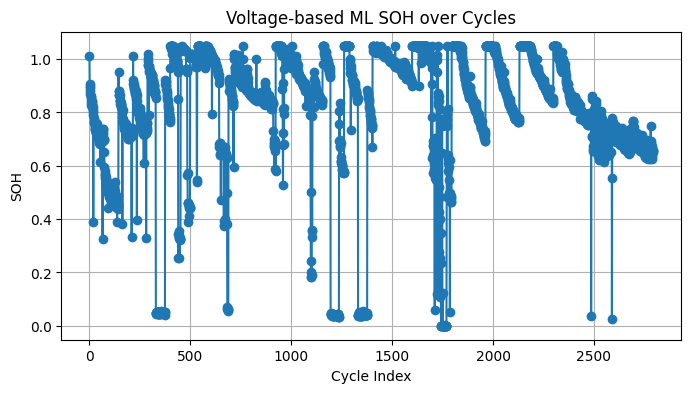

In [31]:
plt.figure(figsize=(8,4))
plt.plot(SOH_voltage_ml, marker='o')
plt.xlabel("Cycle Index")
plt.ylabel("SOH")
plt.title("Voltage-based ML SOH over Cycles")
plt.grid(True)
plt.show()


# Remaining Useful Life (RUL) Prediction

Core Idea

                  RUL = number of remaining cycles until SOH reaches a failure threshold

Typical threshold:

                  SOH = 0.8 (80%) -> industry standard

Prepare SoH vs Cycle Index

You already have:

SoH_cc -> Coulomb-counting SoH

Ordered by discharge cycles

In [32]:
import numpy as np
import matplotlib.pyplot as plt

soh = np.array(SOH_cc)
cycles = np.arange(len(soh))


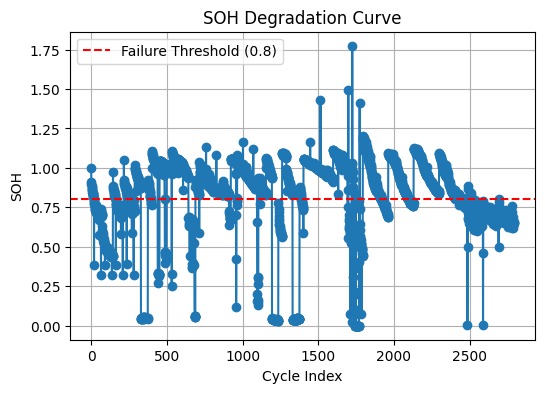

In [33]:
plt.figure(figsize=(6,4))
plt.plot(cycles, soh, marker='o')
plt.axhline(0.8, color='r', linestyle='--', label='Failure Threshold (0.8)')
plt.xlabel("Cycle Index")
plt.ylabel("SOH")
plt.title("SOH Degradation Curve")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
THRESHOLD = 0.8

# Find failure cycle
failure_indices = np.where(soh <= THRESHOLD)[0]

if len(failure_indices) == 0:
    raise ValueError("Battery never reached failure threshold")

failure_cycle = failure_indices[0]

# Compute RUL for each cycle
RUL_true = failure_cycle - cycles
RUL_true[RUL_true < 0] = 0


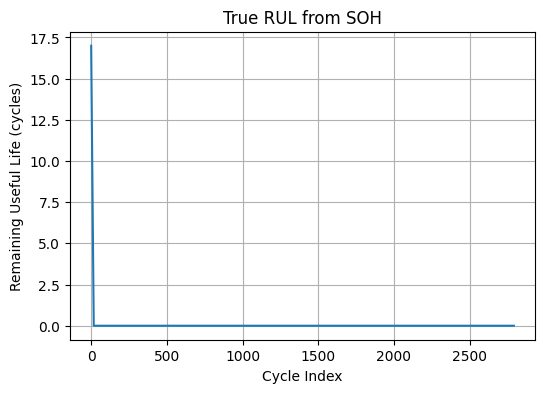

In [35]:
plt.figure(figsize=(6,4))
plt.plot(cycles, RUL_true)
plt.xlabel("Cycle Index")
plt.ylabel("Remaining Useful Life (cycles)")
plt.title("True RUL from SOH")
plt.grid(True)
plt.show()


# ML-based RUL Prediction (Random Forest)

In [36]:
X = X_voltage[:failure_cycle+1]
y = RUL_true[:failure_cycle+1]


Train-Test Split

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Train model

In [38]:
from sklearn.ensemble import RandomForestRegressor

rf_rul = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

rf_rul.fit(X_train, y_train)


RandomForestRegressor(n_estimators=300, random_state=42)

In [39]:
y_pred_rul = rf_rul.predict(X_test)


Evaluation

In [40]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred_rul)
mae


1.995

RUL Prediction Plot

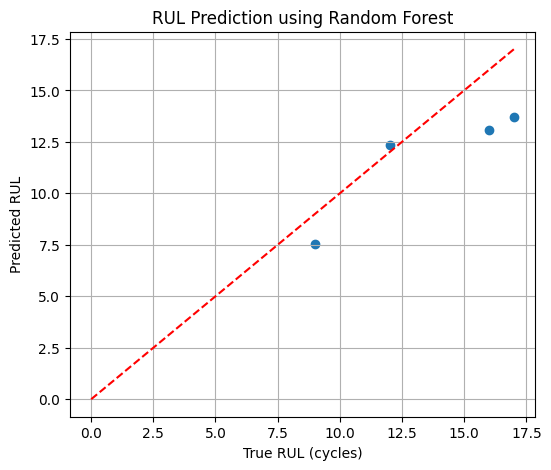

In [41]:
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred_rul)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.xlabel("True RUL (cycles)")
plt.ylabel("Predicted RUL")
plt.title("RUL Prediction using Random Forest")
plt.grid(True)
plt.show()



 The Mean Absolute Error (MAE) for the Voltage-Based SOH prediction model is `0.01609842398191085`. This value indicates that, on average, the model's SOH predictions deviate by approximately 1.6% from the true (Coulomb-counted) SOH values. A low MAE suggests that the model is performing well in estimating the battery's state of health.

The Mean Absolute Error (MAE) for the ML-based RUL prediction model is **1.995**. This value indicates that, on average, the model's Remaining Useful Life (RUL) predictions deviate by approximately 1.995 cycles from the true RUL values.



In [48]:
import joblib

# Save the RUL prediction model
joblib.dump(rf_rul, 'rul_random_forest_model.joblib')

print("RUL prediction model saved as 'rul_random_forest_model.joblib'")

RUL prediction model saved as 'rul_random_forest_model.joblib'


In [49]:
joblib.dump(rf, 'soh_random_forest_model.joblib')

print("SOH prediction model saved as 'soh_random_forest_model.joblib'")

SOH prediction model saved as 'soh_random_forest_model.joblib'
